In [1]:
# There is a bug with the current version of ImageD11 in the site-wide Jupyter env.
# This has been fixed here: https://github.com/FABLE-3DXRD/ImageD11/commit/4af88b886b1775585e868f2339a0eb975401468f
# Until a new release has been made and added to the env, we need to get the latest version of ImageD11 from GitHub
# Put it in your home directory
# USER: Change the path below to point to your local copy of ImageD11:

import os

username = os.environ.get("USER")

id11_code_path = f"/home/esrf/{username}/Code/ImageD11"

import sys

sys.path.insert(0, id11_code_path)

os.environ['OMP_NUM_THREADS']='1'

In [2]:
from matplotlib import pyplot as plt
import numpy as np

import scipy.ndimage as ndi

from ImageD11.nbGui import nb_utils as utils
import ImageD11.sinograms.dataset

from ImageD11.grain import grain
%matplotlib ipympl

In [3]:
# NOTE: For old datasets before the new directory layout structure, we don't distinguish between RAW_DATA and PROCESSED_DATA

### USER: specify your experimental directory

rawdata_path = "/home/esrf/james1997a/Data/ihma439/id11/20231211/RAW_DATA"

!ls -lrt {rawdata_path}

### USER: specify where you want your processed data to go

processed_data_root_dir = "/home/esrf/james1997a/Data/ihma439/id11/20231211/PROCESSED_DATA/James/20240226"

total 1180
drwxr-x---  19 opid11 id11    4096 Dec 11 13:59 FeAu_0p5_tR
drwxr-x---  15 opid11 id11    4096 Dec 11 16:43 FeAu_tR
drwxr-x---   4 opid11 id11    4096 Dec 11 16:57 CeO2_ff_after_tR
drwxr-x---  20 opid11 id11    4096 Dec 12 09:42 FeAu_0p5_tR_nscope
drwxr-x---  19 opid11 id11    4096 Dec 12 15:23 FSH_steel
drwxr-x---   7 opid11 id11    4096 Dec 12 17:44 test_furnace
drwxr-x--- 143 opid11 id11   16384 Dec 13 13:59 FSH_steel_creep
drwxr-x---   4 opid11 id11    4096 Jan  5 15:53 FeAu_creep_no_beam
-rwxr-x---   1 opid11 id11 1183582 Jan 15 10:11 ihma439_id11.h5
drwxr-x---   2 opid11 id11    4096 Jan 17 16:33 __icat__


In [4]:
# USER: pick a sample and a dataset you want to segment

sample = "FeAu_0p5_tR_nscope"
dataset = "top_250um"

In [5]:
# desination of H5 files

dset_path = os.path.join(processed_data_root_dir, sample, f"{sample}_{dataset}", f"{sample}_{dataset}_dataset.h5")

# USER: specify the path to the parameter file

par_path = os.path.join(processed_data_root_dir, 'Fe_refined.par')

e2dx_path = os.path.join(processed_data_root_dir, '../../CeO2/e2dx_E-08-0173_20231127.edf')
e2dy_path = os.path.join(processed_data_root_dir, '../../CeO2/e2dy_E-08-0173_20231127.edf')

In [6]:
# Load the dataset
dset = ImageD11.sinograms.dataset.load(dset_path)

In [7]:
dset.pbpfile = os.path.join(dset.analysispath, dset.dsname + '_pbp_index.h5')

In [8]:
# pbp_array = np.loadtxt('/home/esrf/james1997a/Code/ImageD11/ImageD11/nbGui/S3DXRD/grainsout_all.pbp')

pbp_array = np.loadtxt(dset.pbpfile)
ubi = {}
i,j,n,u,ubi[0,0],ubi[0,1],ubi[0,2],ubi[1,0],ubi[1,1],ubi[1,2],ubi[2,0],ubi[2,1],ubi[2,2] = pbp_array.T
i = i.astype(int) 
i -= i.min()   # position in array / space
j = j.astype(int) 
j -= j.min()
n = n.astype(int)         # total peaks indexing with hkl==int with 0.03
u = u.astype(int)         # unique (h,k,l) labels on indexed peaks

In [9]:
NY = int(i.max()-i.min())+1
i.min(),i.max(),NY

(0, 275, 276)

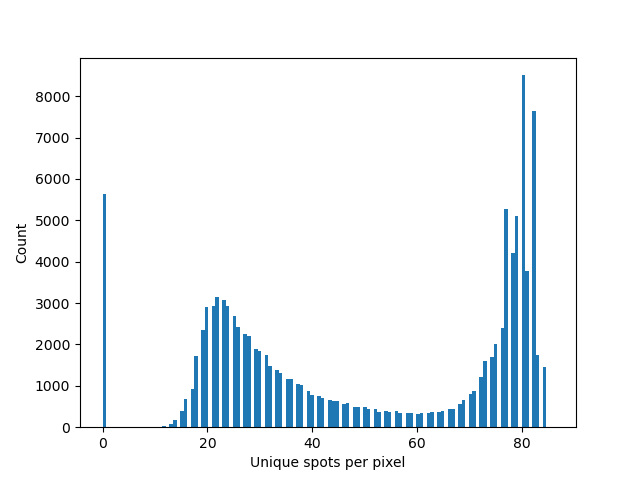

In [10]:
fig, ax = plt.subplots()
ax.hist(u, bins=128)
ax.set_xlabel('Unique spots per pixel')
ax.set_ylabel('Count')
plt.show()

In [11]:
minpeaks = 50

uni = np.ones((NY,NY))
uni.fill(minpeaks) # peak cutorr
npk = np.zeros((NY,NY))
ubifit = np.zeros((NY,NY,3,3), float)
ubifit.fill(np.nan)
ubilist = []
for k in range(len(i)):
    if u[k] > uni[i[k],j[k]]:
        uni[i[k],j[k]] = u[k]
        npk[i[k],j[k]] = n[k]
        for ii in range(3):
            for jj in range(3):
                ubifit[i[k],j[k],ii,jj] = ubi[ii,jj][k]
        ubilist.append(ubifit[i[k],j[k]].copy())

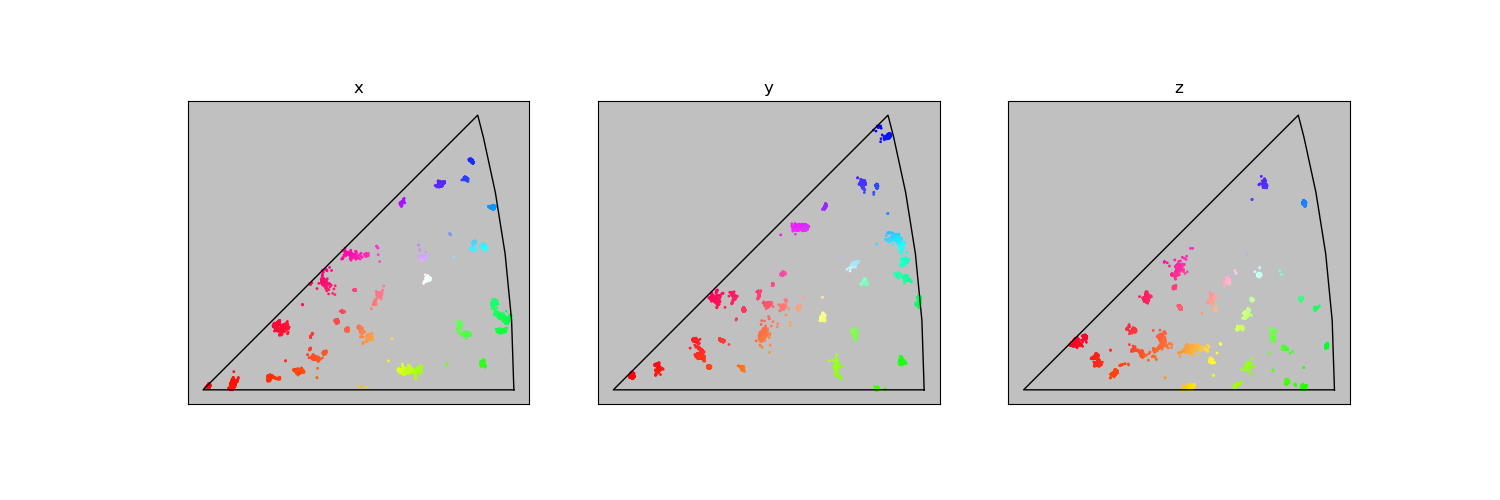

In [12]:
f,a = plt.subplots( 1,3, figsize=(15,5) )
ty, tx = utils.triangle().T
for i,title in enumerate( 'xyz' ):
    ax = np.zeros(3)
    ax[i] = 1.
    hkl = [utils.crystal_direction_cubic( ubi, ax ) for ubi in ubilist]
    xy = np.array( [utils.hkl_to_pf_cubic(h) for h in hkl ] )
    rgb = np.array( [utils.hkl_to_color_cubic(h) for h in hkl ])
    
    a[i].scatter( xy[:,1], xy[:,0], c = rgb, s=1 )   # Note the "x" axis of the plot is the 'k' direction and 'y' is h (smaller)
    a[i].set(title=title, aspect='equal', facecolor='silver', xticks=[], yticks=[])
    a[i].plot( tx, ty, 'k-', lw = 1 )

plt.show()

In [13]:
def normalise( r ):
    negatives = r [r < 0 ]
    noise = np.std(negatives)
    s = ndi.uniform_filter( r, 5 )
    positives =  s > noise
    height = r[positives].mean()
    return np.where(s>noise, r/r.max(), 0)

In [14]:
r = npk.copy()
ubisel = ubifit.copy()

In [15]:
rgb = np.zeros( (3, ubisel.shape[0], ubisel.shape[1], 3 ))
for i in range(ubisel.shape[0]):
    for j in range(ubisel.shape[1]):
        for k,axis in enumerate( ((1,0,0),(0,1,0),(0,0,1)) ):
            if np.isnan( ubisel[i,j,0,0] ):
                rgb[k,i,j] = np.nan
            else:
                rgb[k,i,j] =  utils.hkl_to_color_cubic( utils.crystal_direction_cubic( ubisel[i,j], axis ) )

/cvmfs/hpc.esrf.fr/software/packages/linux/x86_64/jupyter-slurm/2023.10.3/envs/jupyter-slurm/lib/python3.11/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


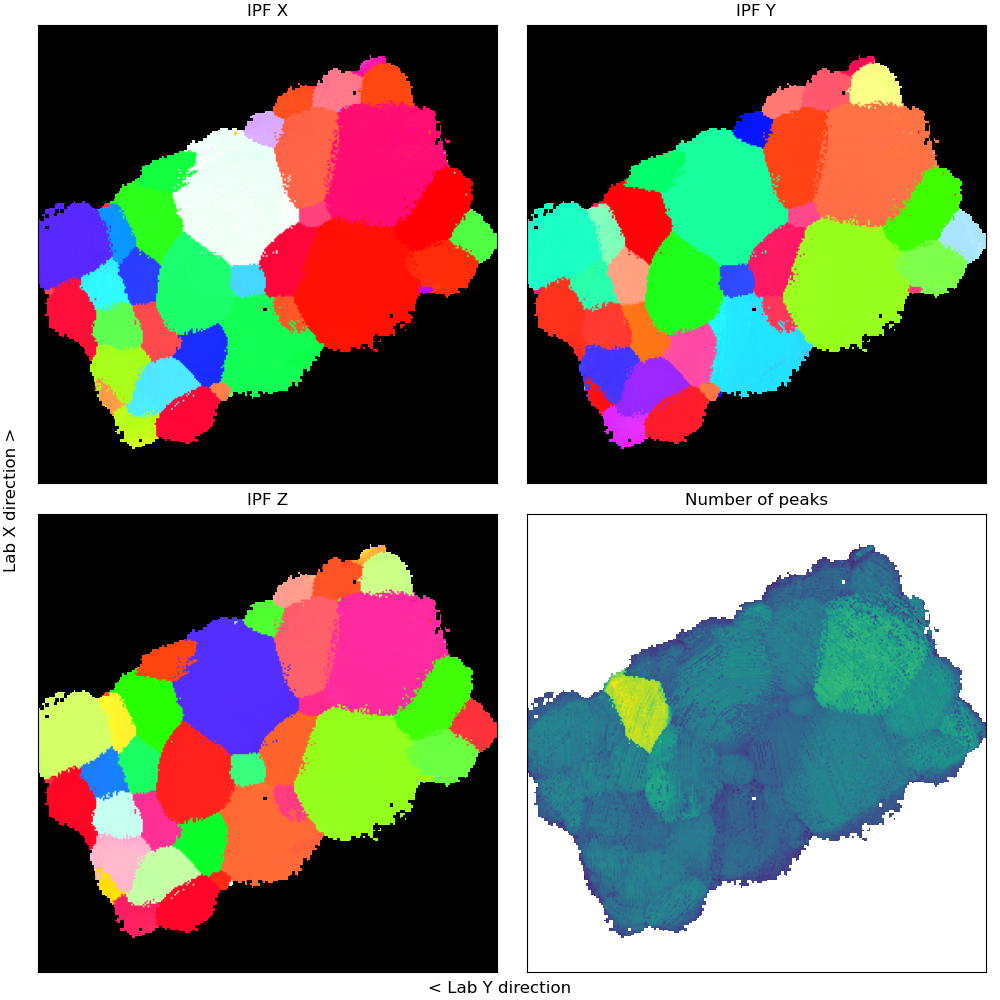

In [16]:
fig, a = plt.subplots(2,2,sharex=True,sharey=True, figsize=(10,10), constrained_layout=True)
a[0][0].imshow(rgb[0].transpose(1, 0, 2), origin="lower")
a[0][0].set_title("IPF X")
a[0][1].imshow(rgb[1].transpose(1, 0, 2), origin="lower")
a[0][1].set_title("IPF Y")
a[1][0].imshow(rgb[2].transpose(1, 0, 2), origin="lower")
a[1][0].set_title("IPF Z")
m = r > 0.02
a[1][1].imshow(np.where(m, r, np.nan).T, origin="lower")
a[1][1].set_title("Number of peaks")
for ax in a.ravel():
    ax.set(yticks=[], xticks=[])
    ax.invert_xaxis()
    ax.invert_yaxis()

fig.supxlabel("< Lab Y direction")
fig.supylabel("Lab X direction >")
plt.show()